# Libs

In [1]:
import os
import torch
import torchvision
import tarfile

from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

import matplotlib 
import matplotlib.pyplot as plt

%matplotlib inline

# Download dataset

In [2]:
# project_name='cifar10-cnn'

# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

0it [00:00, ?it/s]

135110656it [11:40, 3501123.36it/s]                                                                                    

In [3]:
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

135110656it [13:34, 165913.83it/s] 


# Data processing

In [2]:
datapath = './data/cifar10'

print('folders:', os.listdir(datapath))
print('classes:', os.listdir(datapath + '/train'))

folders: ['test', 'train']
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
airplane_files = os.listdir(datapath+ '/train/airplane')
print('len of airplane files: ', len(airplane_files))

len of airplane files:  5000


In [4]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

dataset = ImageFolder(datapath+'/train', transform=ToTensor())

In [5]:
# Check attributes
# dataset.samples
dataset.classes
# dataset.targets

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Label: airplane --(0)--
Label: automobile --(1)--
Label: bird --(2)--
Label: cat --(3)--
Label: deer --(4)--
Label: dog --(5)--
Label: frog --(6)--
Label: horse --(7)--
Label: ship --(8)--
Label: truck --(9)--


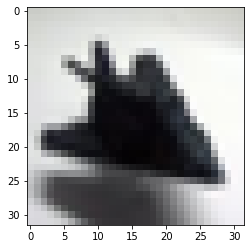

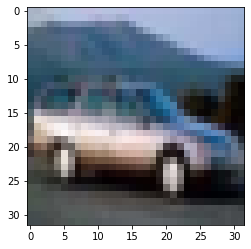

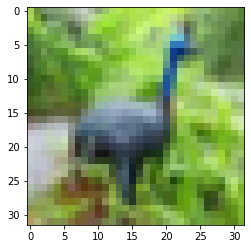

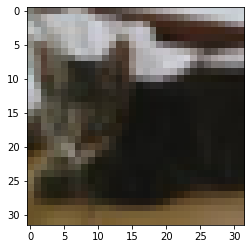

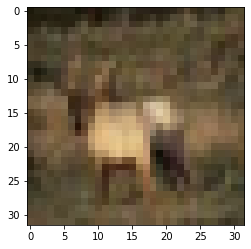

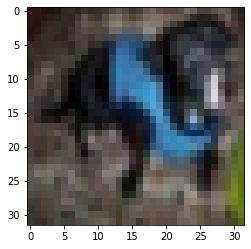

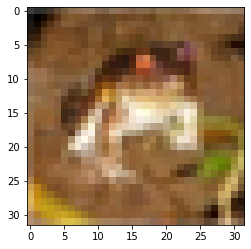

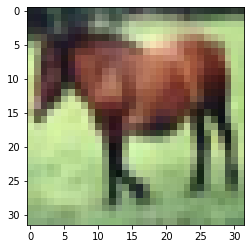

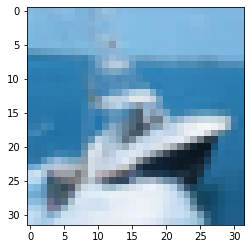

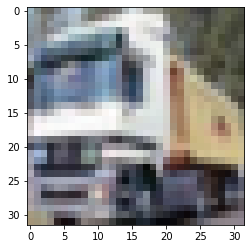

In [6]:
def show_example(image, label):
    plt.figure()
    print('Label:', dataset.classes[label],'--({})--'.format(str(label)))
    plt.imshow(image.permute(1, 2, 0))

# Starred expression to unpack a list
for i in range(0, 50000, 5000): 
    show_example(*dataset[i])

# Model construction

In [7]:
valsize = 5000
trainsize = len(dataset) - 5000

trainset, valset = random_split(dataset, [trainsize, valsize])
len(trainset)

45000

In [8]:
from torch.utils.data.dataloader import DataLoader

batch_size = 128

train_dl = DataLoader(trainset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(valset, batch_size*2, num_workers=4, pin_memory=True)

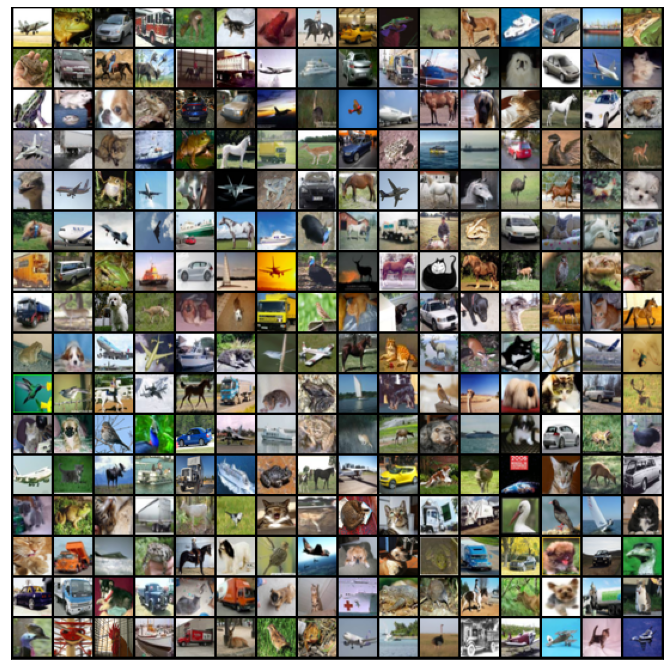

In [9]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(20, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(val_dl)

## Convolution operator

In [10]:
# Let us implement a convolution operation on a 1 channel image with a 3x3 kernel.
def convolution_operator(image, kernel, stride):
    row_in, col_in = image.shape
    row_k, col_k = kernel.shape
    row_out, col_out = row_in-row_k+1, col_in-col_k+1
    
    output = torch.zeros([row_out, col_out])
    
    for i in range(row_out, stride):
        for j in range(col_out, stride):
            output[i,j] = torch.sum(image[i:i+row_k, j:j+col_k] * kernel)
    return output

In [11]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [12]:
class ImageClassification(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        
        return loss
        
    def validation_step(self, batch):
        images, labels = batch 
        outputs = self(images)                    
        loss = F.cross_entropy(outputs, labels)   
        acc = accuracy(outputs, labels)           # Calculate accuracy
        
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_loss = [output['val_loss'] for output in outputs]
        battch_acc = [output['val_acc'] for output in outputs]
        
        ep_loss = torch.stack(batch_loss).mean()
        ep_acc = torch.stack(battch_acc).mean()
        
        return {'val_loss': ep_loss.item(), 'val_acc': ep_acc.item()}
    
    def result_ep_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))   

In [13]:
class CNN_cifar10(ImageClassification):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # In channel = 3, In channel = 32, kernel size = 3
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # Pooling with 2x2 kernel and stride 2
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            
            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        return self.network(x)

In [14]:
model = CNN_cifar10()
model

CNN_cifar10(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024, out_features=512

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
device = get_default_device()
device

device(type='cuda')

In [17]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

to_device(model, device)

CNN_cifar10(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024, out_features=512

In [18]:
@torch.no_grad()

def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.result_ep_end(epoch, result)
        history.append(result)
    return history

In [19]:
num_epochs = 12
lr = 0.001

In [20]:
history_adamw = fit(num_epochs, lr, model, train_dl, val_dl, opt_func=torch.optim.AdamW)

Epoch [0], val_loss: 1.3569, val_acc: 0.4896
Epoch [1], val_loss: 1.0857, val_acc: 0.6085
Epoch [2], val_loss: 0.8898, val_acc: 0.6835
Epoch [3], val_loss: 0.7927, val_acc: 0.7221
Epoch [4], val_loss: 0.7620, val_acc: 0.7376
Epoch [5], val_loss: 0.7434, val_acc: 0.7526
Epoch [6], val_loss: 0.7404, val_acc: 0.7604
Epoch [7], val_loss: 0.8742, val_acc: 0.7440
Epoch [8], val_loss: 0.9400, val_acc: 0.7663
Epoch [9], val_loss: 1.0523, val_acc: 0.7534
Epoch [10], val_loss: 1.0931, val_acc: 0.7530
Epoch [11], val_loss: 1.2773, val_acc: 0.7579


Text(0.5, 1.0, 'Val accuracy vs. No. of epochs')

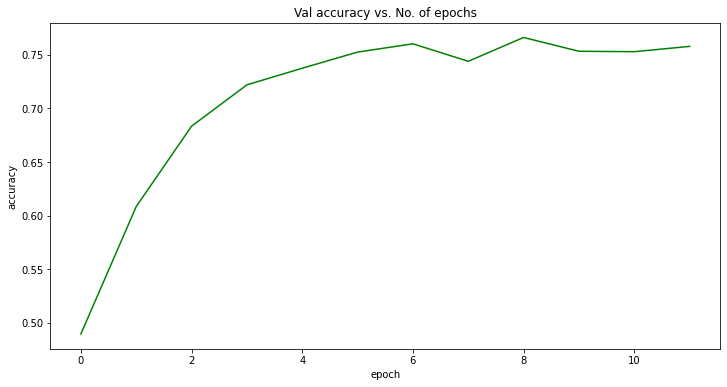

In [21]:
acc_adamw = [result['val_acc'] for result in history_adamw]

plt.figure(figsize=(12,6))

plt.plot(acc_adamw, 'g')


plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Val accuracy vs. No. of epochs')

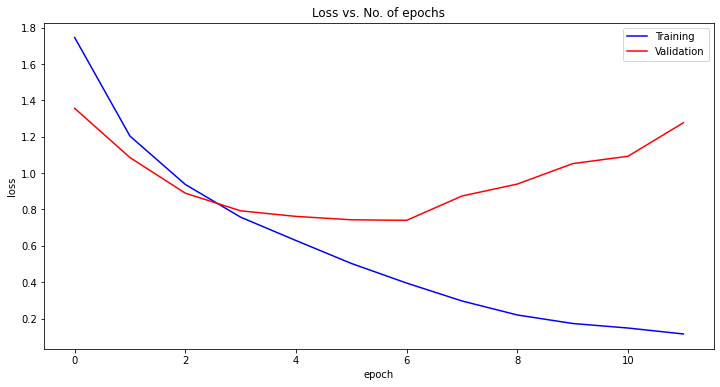

In [22]:
train_losses = [x.get('train_loss') for x in history_adamw]
val_losses = [x['val_loss'] for x in history_adamw]

plt.figure(figsize=(12,6))

plt.plot(train_losses, 'b')
plt.plot(val_losses, 'r')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs');

# predict

In [64]:
def predict_image(img, model):
    # Convert to a batch of 1
    x = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    y = model(x)
    # Pick index with highest probability
    _, preds  = torch.max(y, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

def prediction(valset):
    indexes = [x for x in range(0, 5000, 300)]
    for i in indexes:
        plt.figure()
        img, label = valset[i]
        plt.imshow(img.permute(1, 2, 0))
        print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: airplane , Predicted: airplane
Label: truck , Predicted: truck
Label: bird , Predicted: bird
Label: ship , Predicted: airplane
Label: horse , Predicted: airplane
Label: ship , Predicted: ship
Label: cat , Predicted: deer
Label: bird , Predicted: bird
Label: airplane , Predicted: ship
Label: dog , Predicted: dog
Label: horse , Predicted: horse
Label: truck , Predicted: truck
Label: truck , Predicted: truck
Label: automobile , Predicted: automobile
Label: bird , Predicted: cat
Label: frog , Predicted: bird
Label: automobile , Predicted: automobile


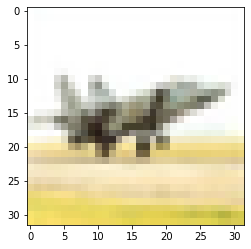

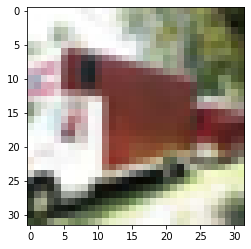

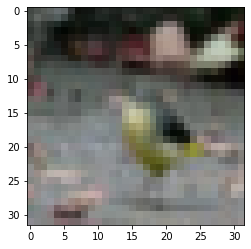

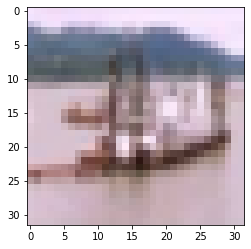

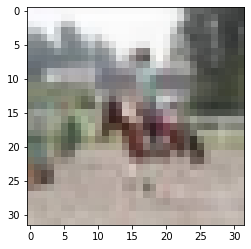

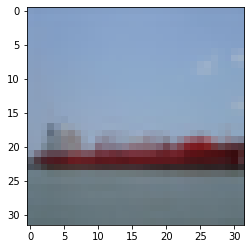

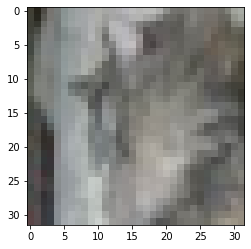

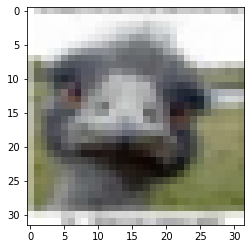

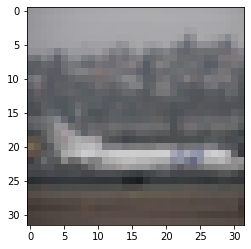

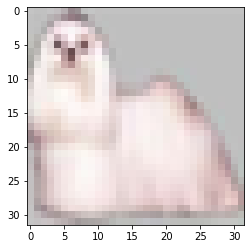

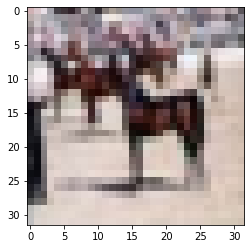

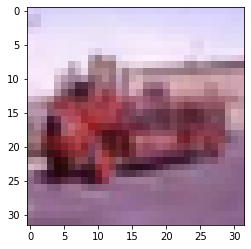

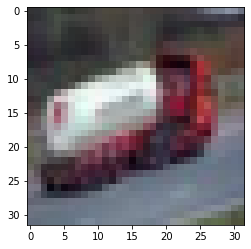

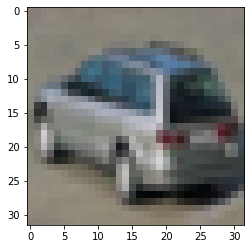

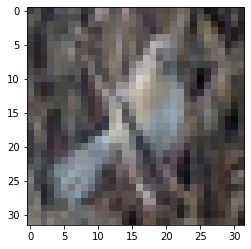

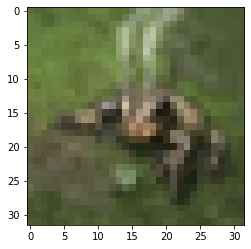

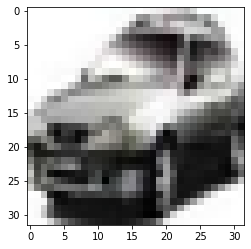

In [65]:
prediction(valset)